This notebook have an example of usage classification pipeline for Alrosa gems color classification.
[Description of the pilot on Confluence](https://confluence.jet.su/pages/viewpage.action?pageId=53248340)

# Pipeline Description

1) **Load data**  
To run pipeline one need to create a dataset (*pd.DataFrame*) with columns:
- **class_name**: *str*
- **obj_id**: *str* - id of one item. Unique for single image classification. Images of the same object must have the same *obj_id* (for multi image classification)
- **img_path**: *str* - path to image
- **target**: *int* - encoding of classes


2) **Set experiment parameters**  
To set parameter we use configuration file with the following structure:   

|Name|Type|Meaning|
|:---------|:----|:--------------------------|
|experiment_param.name|str|name of folder that will be created for storing artefacts of experiment|
|experiment_param.path_save|str|path to the directory where it will be created to store the artifacts of the experiment|
|experiment_param.path_tensorboard|str|path to the directory to which **tensorboard** will write results|
|experiment_param.seed|int|random seed value|
|train_param.num_epochs|int|number of epochs|
|train_param.batch_size|int|size of batch|
|train_param.num_workers|int|number of num_workers for DataLoader|
|train_param.lr|float|learing rate value|
|train_param.cuda_number|int|number of cuda device to train|
|train_param.use_balanced_weights|bool|if True using balanced weights for Loss function|

3) **Split data**  
Split data to train, validation and test parts with obj_id stratification.  
Save pandas DataFrames to experiment folder **experiment_param.name**
It is necessary to save class names to file **metadata.yaml** to print confusion matrix after evaluation

4) **Train model**  
To train model one needs to specify *Config* and path to *experiment folder*.  
During training process model weights are saving to **experiment_folder/model**

<div class="alert alert-block alert-warning">
<b>Note:</b>
<ul>
    <li>By default all layers are trained.</li>
    <li>To train model it is mandatory to have files **train.csv** and **val.csv** in experiment folder.</li>
</ul>
</div>

# Imports

In [41]:
# Imports
import time
import re
from tqdm import tqdm
import os
from sklearn.svm import SVC
import sys
import math
from pprint import pprint as pp
import csv
import pandas as pd
import numpy as np
from PIL import Image
import cv2
from sklearn.model_selection import cross_validate
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten,Dropout ,MaxPooling2D, BatchNormalization
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import glob

sys.path.append('../..') #add root directory of project to import needed modules

from src.train_model import train_model
from src.evaluate_model import evaluate_model
from src.utils.general import load_yaml, save_yaml
from src.utils.metrics import compute_metrics
from src.utils.pipeline import load_model, build_data_loader, freeze_layers
from src.utils.post_processing import aggregate_detailed_classes, aggregate_obj_results
from src.analysis.mistakes import show_mistakes_by_target, show_mistakes_by_pred, plot_proba_distr
import tensorflow
from src.collection import CollectionAttention, CollectionSeparate
from src.models.densenet import densenet121, DenseNetAttn
from src.models.efficeintnet import EfficientnetB3AttnPretrained, EfficientnetB3Pretrained, EfficientnetB3
from src.models.mobilenet import MobileNetV2_
from src.models.resnet import ResNet50
from src.train import TrainerAttention, TrainerSeparate

from etc.alrosa.utils import get_values

%matplotlib inline

In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
 # Disable warnings print
import warnings
warnings.filterwarnings('ignore')

# Set floating point and column format
pd.options.display.float_format = '{:.4f}'.format
pd.set_option('display.max_columns', None)


# Set notebook style in HTML
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

**Dataset** was already collected, one should collect dataset that meet conditions described above

Dataset is supposed to have the following columns:
- *class_name*: str
- *obj_id* - id of one item. Unique for single image classification. Images of the same object must have the same *obj_id* (for multi image classification)
- *img_path*: str - path to image
- *target*: int - encoding of classes



In out case there are 2 images per one gem (from 2 cameras)  
We are going to train model on independent images and then aggregate results over **obj_ids**

In [36]:
cwd = os.getcwd()
print(cwd)

C:\Users\getbb\Documents\classification_pipeline\notebooks\example_experiments


In [37]:
path='C:/Users/getbb/Documents/classification_pipeline/images/my_dataset/'
classnames=[]
def forming_csv(path) :
    global classnames
    classnames=[]
    print('Ожидайте ,оформируется csv.файл')
    with open("C:/Users/getbb/Documents/classification_pipeline/samples/full.csv", mode="w", encoding='utf-8') as w_file :
            file_writer = csv.writer(w_file, delimiter = ",", lineterminator="\r")
            file_writer.writerow(["obj_id","class_name", "img_path", "target"])
            i=0
            j=-1
            for foldername in os.listdir(path): 
                classname=foldername
                for names in glob.glob(os.path.join(path+'/'+foldername, '*.jpg')):
                    names=names.replace("\\",'/')
                    if classname in classnames :
                        file_writer.writerow([i,classname,names,j])
                    else :
                        classnames.append(classname)
                        j+=1
                        file_writer.writerow([i,classname,names,j])
                    i+=1
    print('.csv Файл успешно создан по адресу','C:/Users/getbb/Documents/classification_pipeline/samples/full.csv')
    images = pd.read_csv('C:/Users/getbb/Documents/classification_pipeline/samples/full.csv')
    return images
images = forming_csv('C:/Users/getbb/Documents/classification_pipeline/images/my_dataset/')

Ожидайте ,оформируется csv.файл
.csv Файл успешно создан по адресу C:/Users/getbb/Documents/classification_pipeline/samples/full.csv


In [38]:
def find_face():
    cascadePath = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    faceCascade = cv2.CascadeClassifier(cascadePath)
    for i in range (len(images)):
        img = cv2.imread(images['img_path'][i])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = faceCascade.detectMultiScale(gray,  scaleFactor=1.2, minNeighbors=5,minSize=(20, 20)  )
        if (len(faces)>0) :
            for (x, y, w, h) in faces:
                face=gray[y: y + h, x: x + w]
                resize_face=cv2.resize(face, (224,224))
                path="onlyfaces/"+str(i)+".jpg"
                isWritten =cv2.imwrite(path,resize_face)
                images['img_path'][i]=path
    return
find_face()


# Load data

Загружаем датасеты с разметкой

In [6]:
images.head()

,obj_id,class_name,img_path,target
0,0,Albov_NA,C:/Users/getbb/Documents/classification_pipeli...,0
1,1,Albov_NA,onlyfaces/1.jpg,0
2,2,Albov_NA,C:/Users/getbb/Documents/classification_pipeli...,0
3,3,Albov_NA,C:/Users/getbb/Documents/classification_pipeli...,0
4,4,Albov_NA,C:/Users/getbb/Documents/classification_pipeli...,0


In [7]:
config_path = '../../configs/classification.yaml'
config = load_yaml(config_path)

config['train_param']['cuda_number'] = 1 # put None to use cpu
config["train_param"]['num_epochs'] = 12
config["train_param"]["batch_size"] = 20
config['experiment_param']['name'] = 'classification_classic'


pp(config)

{'experiment_param': {'name': 'classification_classic',
                      'path_save': '../../experiments',
                      'path_tensorboard': '../../experiments/tensorboard',
                      'seed': 50},
 'train_param': {'batch_size': 20,
                 'cuda_number': 1,
                 'lr': 1e-05,
                 'num_epochs': 12,
                 'num_workers': 8,
                 'use_balanced_weights': True}}


In [8]:
SEED = 15

experiment_name = config['experiment_param']['name']
print(experiment_name)
try:
    seed = config['experiment_param']['seed']
except KeyError:
    seed = SEED

path_to_save_exp = os.path.join(config['experiment_param']['path_save'], experiment_name)

print(f'Path for save experiment_name : {path_to_save_exp}')

classification_classic
Path for save experiment_name : ../../experiments\classification_classic


## Полносвязная нейронная Сеть

Создаем тренировочный и тестировочный наборы,,делаем картинки черно-белыми ,нормализуем данные

In [43]:
def load_and_split_data(data) :
    x_train=[]  
    y_train=[]
    x_test=[]
    y_test=[]
    seed=10
    gems = images.groupby(['obj_id'])['target'].first().reset_index()
    train_gems, test_gems = train_test_split(gems, stratify=gems['target'], test_size=0.16, random_state=seed)
    for i in range (len(images)):
        img = cv2.imread(images['img_path'][i])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if(gray.shape[0]!=224) :
            continue
        if images['obj_id'][i] in train_gems['obj_id'] :
            x_train.append(gray)
            y_train.append(images['target'][i])
        else :
            x_test.append(gray)
            y_test.append(images['target'][i])
    return(np.asarray(x_train),np.asarray(y_train),np.asarray(x_test),np.asarray(y_test))
def as_row_matrix (X):
    if len (X) == 0:
        return np. array ([])
    mat = np. empty ((0 , X [0].size ), dtype =X [0]. dtype )
    for row in X:
        mat = np.vstack(( mat , np.asarray( row ).reshape(1 , -1))) # 1 x r*c
    return mat
        
x_train,y_train,x_test,y_test=load_and_split_data(images)
print(x_train.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

(834, 224, 224)


In [48]:
def load_and_split_data(data) :
    print('Формируются данные...')
    x_train=[]  
    y_train=[]
    x_test=[]
    y_test=[]
    seed=10
    cascadePath = "C:/Users/getbb/anaconda3/Lib/site-packages/cv2/data/haarcascade_frontalface_default.xml"
    faceCascade = cv2.CascadeClassifier(cascadePath)
    gems = images.groupby(['obj_id'])['target'].first().reset_index()
    train_gems, test_gems = train_test_split(gems, stratify=gems['target'], test_size=0.16, random_state=seed)
    for i in range (len(images)):
        img = cv2.imread(images['img_path'][i])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = faceCascade.detectMultiScale(gray,  scaleFactor=1.2, minNeighbors=5,minSize=(20, 20)  )
        if images['obj_id'][i] in train_gems['obj_id'] :
            for (x, y, w, h) in faces:
                face=gray[y: y + h, x: x + w]
                resize_face=cv2.resize(face, (224,224))
                x_train.append(resize_face)
                y_train.append(images['target'][i])
        else :
            for (x, y, w, h) in faces:
                face=gray[y: y + h, x: x + w]
                resize_face=cv2.resize(face, (224,224))
                x_test.append(resize_face)
                y_test.append(images['target'][i])
    return(np.asarray(x_train),np.asarray(y_train),np.asarray(x_test),np.asarray(y_test))   
def as_row_matrix (X):
    if len (X) == 0:
        return np. array ([])
    mat = np. empty ((0 , X [0].size ), dtype =X [0]. dtype )
    for row in X:
        mat = np.vstack(( mat , np.asarray( row ).reshape(1 , -1))) # 1 x r*c
    return mat
x_train,y_train,x_test,y_test=load_and_split_data(images)


Формируются данные...


TypeError: 'tuple' object is not callable

In [50]:
time1=time.time()

SVC_model = SVC(kernel= 'poly', degree = 2)
SVC_model.fit(as_row_matrix(x_train), y_train)
print(time.time()-time1)

0.36595988273620605


Преобразует вектор класса (целые числа) в двоичную матрицу классов.

In [19]:
x_train = x_train.reshape(len(y_train), 50176)
x_test = x_test.reshape(len(y_test), 50176)
x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255

In [26]:
model = Sequential()
model.add(Dense(350, input_dim=50176, activation='relu'))
model.add(Dense(315))
model.add(Dense(280))
model.add(Dense(5,activation='softmax'))
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
time1 = time.time()
history = model.fit(x_train, y_train, epochs=11, verbose=2, validation_data=(x_test, y_test))
print(time.time()-time1)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 350)               17561950  
                                                                 
 dense_39 (Dense)            (None, 315)               110565    
                                                                 
 dense_40 (Dense)            (None, 280)               88480     
                                                                 
 dense_41 (Dense)            (None, 5)                 1405      
                                                                 
Total params: 17,762,400
Trainable params: 17,762,400
Non-trainable params: 0
_________________________________________________________________
Epoch 1/11
27/27 - 2s - loss: 34.0897 - accuracy: 0.3153 - val_loss: 1.2766 - val_accuracy: 0.4812 - 2s/epoch - 71ms/step
Epoch 2/11
27/27 - 2s - loss: 0.9369 - accuracy: 0.

## Сверточная нейронная сеть

In [28]:
x_train = x_train.reshape(len(y_train), 224,224,1)
x_test = x_test.reshape(len(y_test),224,224,1)
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255

In [29]:
model = Sequential()
model.add(Conv2D(64, kernel_size=3, activation='elu', input_shape=(224,224,1)))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(x_train, y_train, epochs=16, verbose=2, validation_data=(x_test, y_test))

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 64)      640       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 64)     0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 788544)            0         
                                                                 
 dense_42 (Dense)            (None, 5)                 3942725   
                                                                 
Total params: 3,943,365
Trainable params: 3,943,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/16
27/27 - 16s - loss: 19.5151 - accuracy: 0.4365 - val_loss: 0.8466 - val_accuracy: 0.7625 - 16s/epo

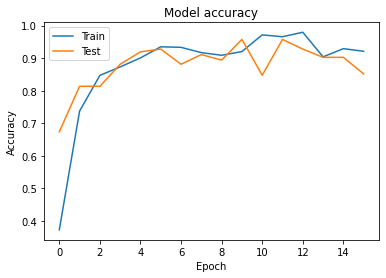

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Полносвязная нейронная сеть работает с точностью 50 процентов.

In [22]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [166]:
images['img_path'].iloc[0]

'onlyfaces/0.jpg'

In [167]:
images.class_name.unique()

array(['Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush',
       'Gerhard_Schroeder', 'Hugo_Chavez', 'Junichiro_Koizumi'],
      dtype=object)

In [168]:
images.head()
img = cv2.imread(images['img_path'][0])
print(img)

[[[128 128 128]
  [129 129 129]
  [130 130 130]
  ...
  [ 84  84  84]
  [ 87  87  87]
  [ 90  90  90]]

 [[129 129 129]
  [129 129 129]
  [130 130 130]
  ...
  [ 87  87  87]
  [ 89  89  89]
  [ 91  91  91]]

 [[126 126 126]
  [127 127 127]
  [128 128 128]
  ...
  [ 92  92  92]
  [ 93  93  93]
  [ 94  94  94]]

 ...

 [[ 22  22  22]
  [ 22  22  22]
  [ 22  22  22]
  ...
  [ 19  19  19]
  [ 18  18  18]
  [ 18  18  18]]

 [[ 22  22  22]
  [ 22  22  22]
  [ 22  22  22]
  ...
  [ 19  19  19]
  [ 18  18  18]
  [ 18  18  18]]

 [[ 22  22  22]
  [ 22  22  22]
  [ 22  22  22]
  ...
  [ 18  18  18]
  [ 18  18  18]
  [ 19  19  19]]]


Split shapes for train / val / test: 1364 / 241 / 284 

Preprocessing stage is finished.


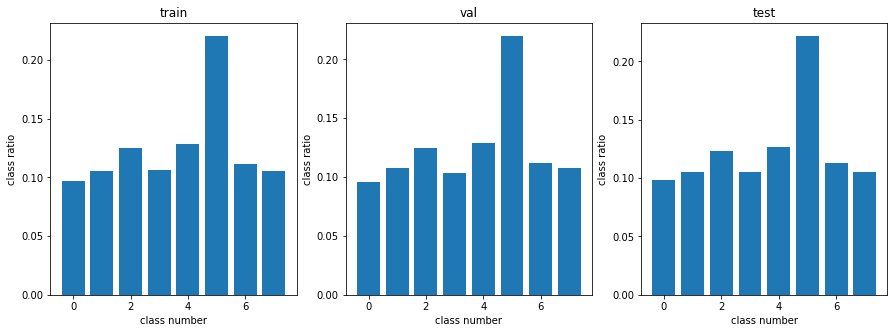

In [24]:
seed = 115
# split by obj_id STRATIFY
gems = images.groupby(['obj_id'])['target'].first().reset_index()

train_gems, test_gems = train_test_split(gems, stratify=gems['target'], test_size=0.15, random_state=seed)
train_gems, val_gems = train_test_split(train_gems, stratify=train_gems['target'], test_size=0.15, random_state=seed)

i=0
for x in train_gems['target']:
    if x== 0:
        i+=1
train_gems = train_gems['obj_id'].values
val_gems = val_gems['obj_id'].values
test_gems = test_gems['obj_id'].values

train = images[images['obj_id'].isin(train_gems)].reset_index(drop=True)
val = images[images['obj_id'].isin(val_gems)].reset_index(drop=True)
test = images[images['obj_id'].isin(test_gems)].reset_index(drop=True)

print(f'Split shapes for train / val / test: {train.shape[0]} / {val.shape[0]} / {test.shape[0]} \n')
fig, axs = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)

train_cls_ratio = train['target'].value_counts().sort_index() / len(train)
val_cls_ratio = val['target'].value_counts().sort_index() / len(val)
test_cls_ratio = test['target'].value_counts().sort_index() / len(test)

axs[0].bar(train_cls_ratio.index, train_cls_ratio.values)
axs[1].bar(val_cls_ratio.index, val_cls_ratio.values)
axs[2].bar(test_cls_ratio.index, test_cls_ratio.values)

for i, split_name in enumerate(['train', 'val', 'test']):
    axs[i].title.set_text(split_name)
    axs[i].set_xlabel('class number')
    axs[i].set_ylabel('class ratio')
    
if not os.path.exists(path_to_save_exp):
    os.makedirs(path_to_save_exp)

# save data sets
train.to_csv(os.path.join(path_to_save_exp, 'train.csv'), index=False)
val.to_csv(os.path.join(path_to_save_exp, 'val.csv'), index=False)
test.to_csv(os.path.join(path_to_save_exp, 'test.csv'), index=False)

save_yaml({'class_names': classnames}, os.path.join(path_to_save_exp, 'metadata.yaml'))
print('Preprocessing stage is finished.')

In [25]:
images.target.value_counts()

5    417
4    242
2    236
6    211
1    200
3    200
7    200
0    183
Name: target, dtype: int64

<AxesSubplot:>

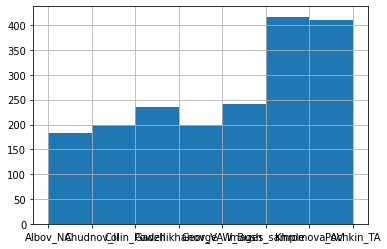

In [26]:
images.class_name.hist(bins=7)

# Train model

In [27]:
experiment_folder_path = path_to_save_exp
print('Experiment path: \t', experiment_folder_path)

Experiment path: 	 ../../experiments/classification_classic


In [28]:
images.target.nunique()

8

In [29]:
!ls $experiment_folder_path

metadata.yaml  model  results  test.csv  train.csv  val.csv


In [30]:
#Model = EfficientnetB3Pretrained(num_classes=images.target.nunique())
Model = ResNet50(num_classes=images.target.nunique())
Trainer = TrainerSeparate
Collection = CollectionSeparate

criterion = torch.nn.MSELoss
optimizer = torch.optim.Adam

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [31]:
images.target.unique()

array([0, 1, 2, 3, 4, 5, 6, 7])

In [32]:
experiment_folder_path

'../../experiments/classification_classic'

In [ ]:
best_epoch = train_model(
    Model,
    Trainer,
    Collection,
    criterion,
    optimizer,
    config,
    experiment_folder_path,
    epoch_to_load=None
)

In [25]:
best_epoch

9

In [26]:
Collection

src.collection.collection_sep.CollectionSeparate

## Scenario 2

На обычном трейн тест сплите

In [177]:
best_epoch

11

Starting model validation stage on test.csv set...


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:14<00:00,  2.07s/it]


Accuracy:  0.904
Precision:  0.9168317460317461
Recall:  0.904
Class. report:
                    precision    recall  f1-score   support

     Colin_Powell       0.96      0.87      0.92        31
  Donald_Rumsfeld       0.89      0.94      0.91        17
    George_W_Bush       1.00      0.90      0.95        42
Gerhard_Schroeder       0.70      0.88      0.78        16
      Hugo_Chavez       0.91      0.91      0.91        11
Junichiro_Koizumi       0.80      1.00      0.89         8

         accuracy                           0.90       125
        macro avg       0.88      0.92      0.89       125
     weighted avg       0.92      0.90      0.91       125



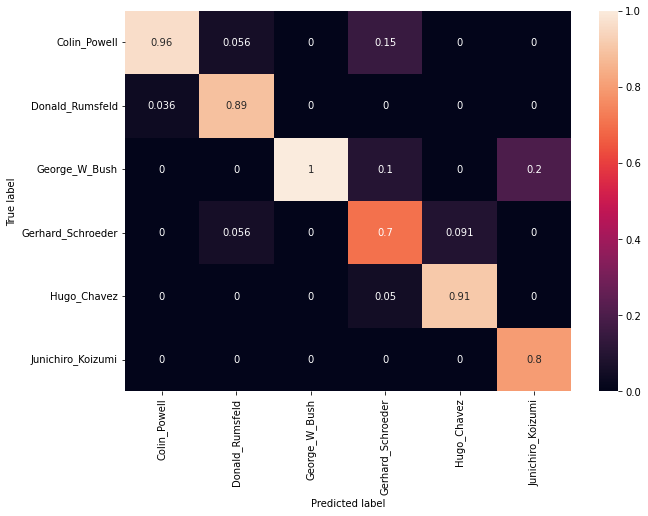

Conf. matrix:
 [[27  1  0  3  0  0]
 [ 1 16  0  0  0  0]
 [ 0  0 38  2  0  2]
 [ 0  1  0 14  1  0]
 [ 0  0  0  1 10  0]
 [ 0  0  0  0  0  8]]
Model evaluation is finished.


In [178]:
Model = ResNet50(num_classes=images.target.nunique())
Collection = CollectionSeparate

pred, results = evaluate_model(
    Model,
    Collection,
    experiment_folder_path, 
    'test', 
    config,
    best_epoch, 
)